# WNN on in vitro data only

In [174]:
here::i_am("rna_atac/dimensionality_reduction/01_WNN_MOFA.ipynb")

source(here::here("settings.R"))
source(here::here("utils.R"))

suppressPackageStartupMessages(library(scran))
suppressPackageStartupMessages(library(scater))
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(batchelor))

BPPARAM <- BiocParallel::bpparam()
BPPARAM$workers = 21

# Multi core using future - built in to seurat
plan("multicore", workers = 1)
options(future.globals.maxSize = 50 * 1024 ^ 3) # for 50 Gb RAM

here() starts at /rds/project/rds-SDzz0CATGms/users/bt392/09_Eomes_invitro_blood/code



In [175]:
args = list()
# ATAC
args$atac_metadata = file.path(io$basedir, 'results/atac/archR/qc/sample_metadata_update_PeakClusters.txt.gz')
args$atac_lsi = file.path(io$basedir, 'results/atac/archR/dimensionality_reduction/cells/PeakMatrix/remove_ExE_cells_FALSE/batch_correction_None/lsi_nfeatures25000_dims20.txt.gz')
# RNA
args$rna_metadata = file.path(io$basedir, '/results/rna/mapping/sample_metadata_after_mapping.txt.gz')
args$rna_pca = file.path(io$basedir, 'results/rna/dimensionality_reduction/sce/none/pca_features1500_pcs15.txt.gz')
args$rna_sce = file.path(io$basedir, 'processed/rna/SingleCellExperiment.rds')

# outdir
args$outdir = file.path(io$basedir, 'results/rna_atac/dimensionality_reduction/')
dir.create(args$outdir, recursive=TRUE, showWarnings =FALSE)

In [176]:
##########################
## Load sample metadata ##
##########################

metadata_atac <- fread(args$atac_metadata) %>%
  .[pass_atacQC==TRUE & doublet_call==FALSE | pass_atacQC==TRUE & is.na(doublet_call)] %>% 
  .[,exp := str_replace_all(sample, opts$sample2exp)]

metadata_rna <- fread(args$rna_metadata) %>%
  .[pass_rnaQC==TRUE & doublet_call==FALSE] %>% 
  .[,exp := str_replace_all(sample, opts$sample2exp)]

In [177]:
unique(metadata_atac$genotype)

[1] "WT" ""   "KO"

#### Plotting functions

In [178]:
plot_umap = function(umap.dt){

dot_size = 5
text_size = 15
title_size = 20

# Plot umap
p1 = ggplot(umap.dt, aes(UMAP1, UMAP2, col=exp)) + 
    geom_point(size=0.2) + 
    scale_color_manual(values=c('exp1' = 'deepskyblue', 'exp2' = 'salmon'), name='') +
    guides(colour = guide_legend(override.aes = list(size=dot_size))) + 
    ggtitle('Experiment') +
    theme_void() +
    theme(text=element_text(size=text_size), 
         plot.title=element_text(size=title_size), 
         legend.position='bottom')

umap.dt$day_genotype = paste0(umap.dt$day, '-', umap.dt$genotype)
umap.dt$day_genotype = gsub('KO', 'KD', umap.dt$day_genotype)
umap.dt$day_genotype = factor(umap.dt$day_genotype, levels=c('D3-WT','D3.5-WT','D3.5-KD','D4-WT','D4-KD','D4.5-WT','D4.5-KD','D5-WT','D5-KD'))

# Plot umap
p2 = ggplot(umap.dt, aes(UMAP1, UMAP2, col=day_genotype)) + 
    geom_point(size=0.2) + 
    scale_color_manual(values=c('D3-WT' = 'purple', 
                                'D3.5-WT' = 'darkgreen', 
                                'D3.5-KD' = 'limegreen',
                                'D4-WT' = 'darkgoldenrod', 
                                'D4-KD' = 'gold',
                                'D4.5-WT' = 'darkblue',
                                'D4.5-KD' = 'deepskyblue', 
                                'D5-WT' = 'darkred',
                                'D5-KD' = 'red'
                               ), name='') +
    guides(colour = guide_legend(override.aes = list(size=dot_size))) + 
    ggtitle('Day-Genotype') +
    theme_void() +
    theme(text=element_text(size=text_size), 
         plot.title=element_text(size=title_size), 
         legend.position='bottom')

# Plot umap
p3 = ggplot(umap.dt, aes(UMAP1, UMAP2, col=genotype)) + 
    geom_point(size=0.2) + 
    scale_color_manual(values=opts$genotype.colors, name='') + 
    guides(colour = guide_legend(override.aes = list(size=dot_size))) + 
    ggtitle('Genotype') +
    theme_void() +
    theme(text=element_text(size=text_size), 
         plot.title=element_text(size=title_size), 
         legend.position='bottom')

options(repr.plot.width=20, repr.plot.height=6)
plots = ggarrange(p1, p2, p3, ncol=3)
return(plots)
}

### Load files

In [179]:
# load LSI
LSI = fread(args$atac_lsi)

# load PCA
PCA = fread(args$rna_pca)

In [180]:
for(i in 1:(dim(LSI)-1)[2]){
    cat(paste0('LSI ', i, ' read depth correlation: ', abs(round(cor(copy(LSI)[,cell:=NULL][,..i], log10(metadata_atac$nFrags_atac+1)), 3)), '\n'))
}

LSI 1 read depth correlation: 0.012
LSI 2 read depth correlation: 0.235
LSI 3 read depth correlation: 0.026
LSI 4 read depth correlation: 0.386
LSI 5 read depth correlation: 0.749
LSI 6 read depth correlation: 0.088
LSI 7 read depth correlation: 0.019
LSI 8 read depth correlation: 0.444
LSI 9 read depth correlation: 0.482
LSI 10 read depth correlation: 0.259
LSI 11 read depth correlation: 0.269
LSI 12 read depth correlation: 0.057
LSI 13 read depth correlation: 0.431
LSI 14 read depth correlation: 0.27
LSI 15 read depth correlation: 0.465
LSI 16 read depth correlation: 0.215
LSI 17 read depth correlation: 0.371
LSI 18 read depth correlation: 0.297
LSI 19 read depth correlation: 0.303
LSI 20 read depth correlation: 0.367


In [181]:
# Filter cells
cells_keep = intersect(metadata_atac$cell, metadata_rna$cell)
metadata_atac = metadata_atac[match(cells_keep, cell)]
metadata_rna = metadata_rna[match(cells_keep, cell)]

# metadata_atac contains all info from RNA as well as ATAC
sample_metadata = metadata_atac

# load sce
rna.sce <- load_SingleCellExperiment(args$rna_sce, normalise = TRUE, cells = sample_metadata$cell)

In [182]:
#sample_metadata = sample_metadata[,Clusters_PeakMatrix2:=NULL] # need to remove duplicated column

In [183]:
fwrite(sample_metadata, sprintf('%s/results/rna_atac/combined_metadata.txt.gz',io$basedir))

In [184]:
# format LSI
LSI = LSI[match(sample_metadata$cell, cell)] %>% 
    as.data.frame(.) %>% 
    tibble::column_to_rownames('cell') %>%
    as.matrix(.)

# format PCA
PCA = PCA[match(sample_metadata$cell, cell)] %>% 
    as.data.frame(.) %>% 
    tibble::column_to_rownames('cell') %>%
    as.matrix(.)

In [185]:
## Create Seurat object
seurat = as.Seurat(rna.sce)

# Add dimensionality reductions
seurat[["PCA"]] <- CreateDimReducObject(embeddings = PCA, key = "PC_", assay = DefaultAssay(seurat))
seurat[["LSI"]] <- CreateDimReducObject(embeddings = LSI, key = "LSI_", assay = DefaultAssay(seurat))

seurat[["PCA_scaled"]] <- CreateDimReducObject(embeddings = scale(PCA), key = "PC_", assay = DefaultAssay(seurat))
seurat[["LSI_scaled"]] <- CreateDimReducObject(embeddings = scale(LSI), key = "LSI_", assay = DefaultAssay(seurat))

Warning message:
“Cannot add objects with duplicate keys (offending key: PC_), setting key to 'pca_scaled_'”
Warning message:
“Cannot add objects with duplicate keys (offending key: LSI_), setting key to 'lsi_scaled_'”


In [186]:
seurat[["PCA_LSI"]] <- CreateDimReducObject(embeddings = cbind(scale(LSI)[,1:20], scale(PCA)[,1:15]), key = "concat_", assay = DefaultAssay(seurat))

### WNN raw DimRedu

In [187]:
seurat <- FindMultiModalNeighbors(seurat, 
                                  reduction.list = list("PCA", "LSI"), 
                                  dims.list = list(1:15, 1:20), 
                                  modality.weight.name = "RNA.weight", 
                                  verbose=FALSE
)

Warning message in FindMultiModalNeighbors(seurat, reduction.list = list("PCA", :
“The number of provided modality.weight.name is not equal to the number of modalities. RNA.weight RNA.weight are used to store the modality weights”


In [190]:
seurat <- RunUMAP(seurat, 
                  nn.name = "weighted.nn", 
                  reduction.name = "wnn.umap", 
                  reduction.key = "wnnUMAP_",
                  n.neighbors = 25,
                  min.dist = 0.25,
                  metric = 'euclidean',
                  verbose = FALSE)

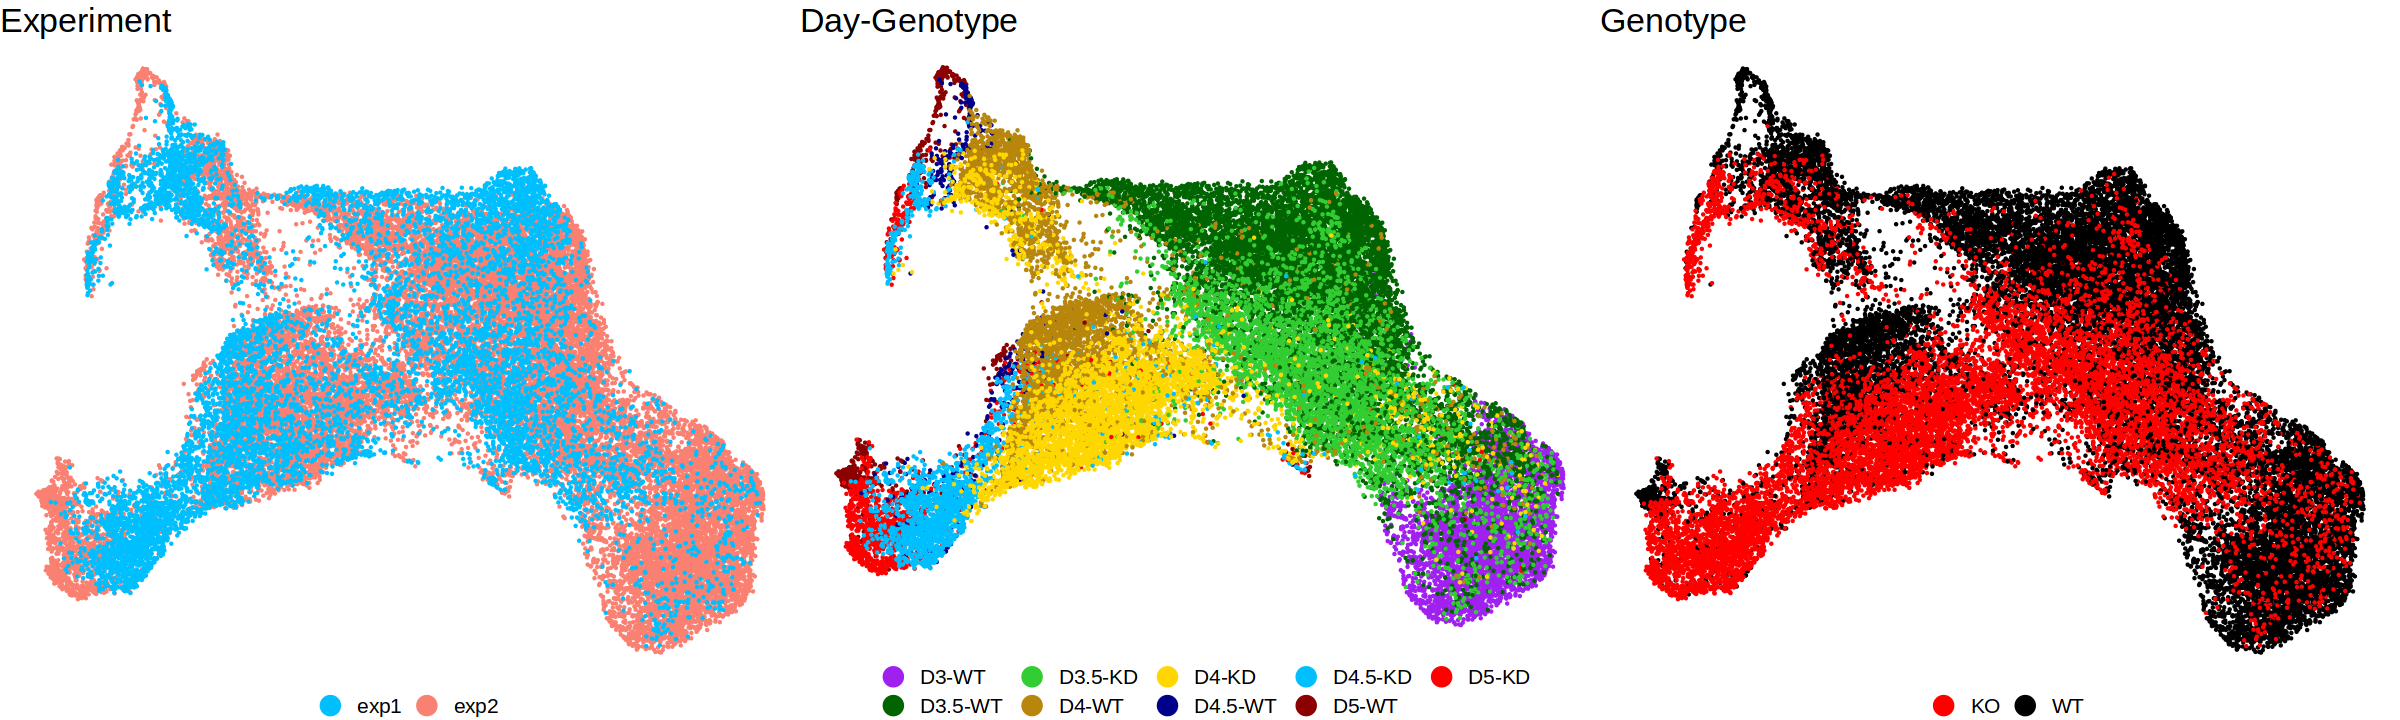

In [191]:
umap.dt = as.data.table(seurat@reductions$wnn.umap@cell.embeddings, keep.rownames=T) %>%
    setnames(c('cell', 'UMAP1', 'UMAP2')) %>%
    merge(., sample_metadata, by='cell')
plot_umap(umap.dt)

In [192]:
pdf(sprintf('%s/WNN_umap.pdf', args$outdir), width=15, height=5)
    plot_umap(umap.dt[,UMAP1:=UMAP1*-1][,UMAP2:=UMAP2*-1])
dev.off()

png 
  2

In [51]:
seurat <- FindMultiModalNeighbors(seurat, 
                                  reduction.list = list("PCA_scaled", "LSI_scaled"), 
                                  dims.list = list(1:15, 1:20), 
                                  modality.weight.name = "RNA.weight", 
                                  verbose=FALSE
)

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from normpca_scaled_ to normpcascaled_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to normpcascaled_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from normlsi_scaled_ to normlsiscaled_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to normlsiscaled_”
Warning message in FindMultiModalNeighbors(seurat, reduction.list = list("PCA_scaled", :
“The number of provided modality.weight.name is not equal to the number of modalities. RNA.weight RNA.weight are used to store the modality weights”


In [52]:
seurat <- RunUMAP(seurat, 
                  nn.name = "weighted.nn", 
                  reduction.name = "wnn.umap", 
                  reduction.key = "wnnUMAP_",
                  n.neighbors = 25L,
                  min.dist = 0.15,
                  metric = 'euclidean',
                  verbose = FALSE)

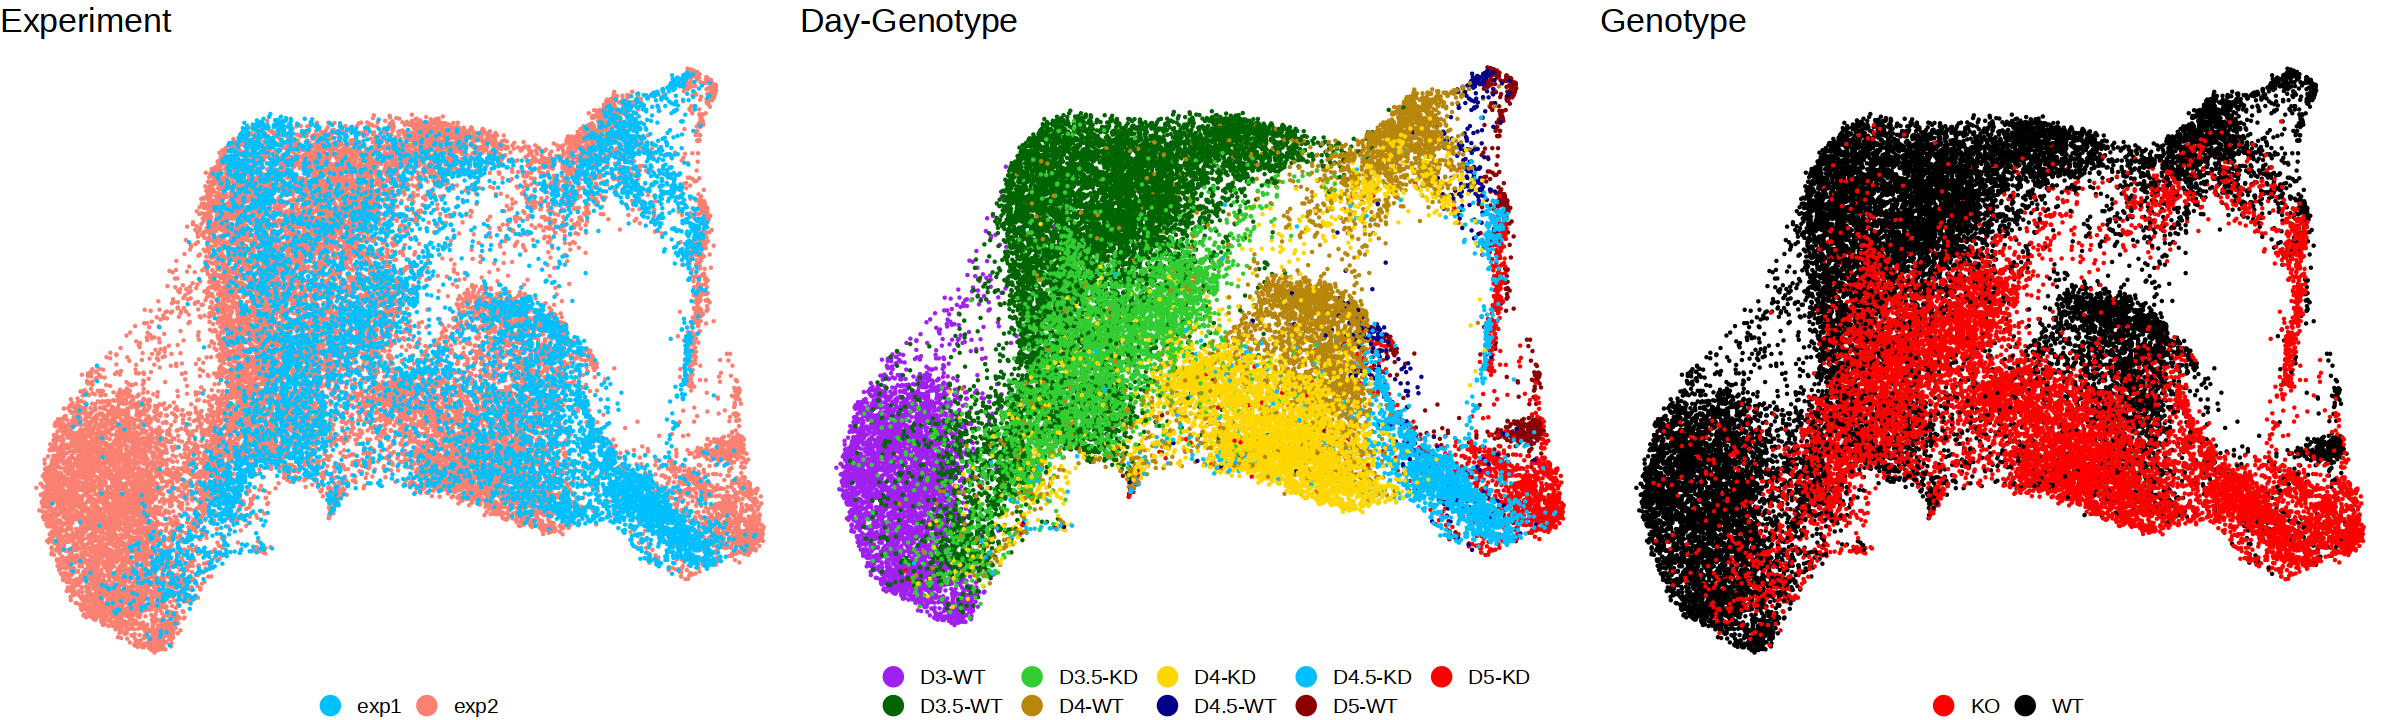

In [53]:
umap.dt = as.data.table(seurat@reductions$wnn.umap@cell.embeddings, keep.rownames=T) %>%
    setnames(c('cell', 'UMAP1', 'UMAP2')) %>%
    merge(., sample_metadata, by='cell')
plot_umap(umap.dt)

# MOFA

In [212]:
# outdir
args$outdir = file.path(io$basedir, 'results/rna_atac/dimensionality_reduction/mofa/')
dir.create(args$outdir, recursive=TRUE, showWarnings =FALSE)

In [9]:
library(MOFA2)


Attaching package: ‘MOFA2’


The following object is masked from ‘package:stats’:

    predict




In [86]:
MOFAobject <- create_mofa(list(t(scale(PCA[,1:15])), t(scale(LSI[,1:20]))))

Creating MOFA object from a list of matrices (features as rows, sample as columns)...


View names are not specified in the data, using default: view_1, view_2




In [83]:
data_opts <- get_default_data_options(MOFAobject)
head(data_opts)

$scale_views
[1] FALSE

$scale_groups
[1] FALSE

$center_groups
[1] TRUE

$use_float32
[1] TRUE

$views
[1] "view_1" "view_2"

$groups
[1] "group1"

In [84]:
model_opts <- get_default_model_options(MOFAobject)
head(model_opts)

$likelihoods
    view_1     view_2 
"gaussian" "gaussian" 

$num_factors
[1] 25

$spikeslab_factors
[1] FALSE

$spikeslab_weights
[1] FALSE

$ard_factors
[1] FALSE

$ard_weights
[1] TRUE

In [85]:
train_opts <- get_default_training_options(MOFAobject)
head(train_opts)

$maxiter
[1] 1000

$convergence_mode
[1] "fast"

$drop_factor_threshold
[1] -1

$verbose
[1] FALSE

$startELBO
[1] 1

$freqELBO
[1] 5

In [92]:
MOFAobject <- prepare_mofa(
  object = MOFAobject,
  data_options = data_opts,
  model_options = model_opts,
  training_options = train_opts
)

Checking data options...

Checking training options...

Checking model options...



In [93]:
outfile = file.path(args$outdir,"model_v2.hdf5")
MOFAobject.trained <- run_mofa(MOFAobject, outfile)

Connecting to the mofapy2 python package using reticulate (use_basilisk = FALSE)... 
    Please make sure to manually specify the right python binary when loading R with reticulate::use_python(..., force=TRUE) or the right conda environment with reticulate::use_condaenv(..., force=TRUE)
    If you prefer to let us automatically install a conda environment with 'mofapy2' installed using the 'basilisk' package, please use the argument 'use_basilisk = TRUE'


6 factors were found to explain no variance and they were removed for downstream analysis. You can disable this option by setting load_model(..., remove_inactive_factors = FALSE)

Warning message in .quality_control(object, verbose = verbose):
“Factor(s) 1 are strongly correlated with the total number of expressed features for at least one of your omics. Such factors appear when there are differences in the total 'levels' between your samples, *sometimes* because of poor normalisation in the preprocessing steps.
”


In [92]:
MOFAobject.trained = load_model(file.path(args$outdir,"model_v2.hdf5"))

6 factors were found to explain no variance and they were removed for downstream analysis. You can disable this option by setting load_model(..., remove_inactive_factors = FALSE)

Warning message in .quality_control(object, verbose = verbose):
“Factor(s) 1 are strongly correlated with the total number of expressed features for at least one of your omics. Such factors appear when there are differences in the total 'levels' between your samples, *sometimes* because of poor normalisation in the preprocessing steps.
”


In [93]:
MOFAobject.trained

Trained MOFA with the following characteristics: 
 Number of views: 2 
 Views names: view_1 view_2 
 Number of features (per view): 15 20 
 Number of groups: 1 
 Groups names: group1 
 Number of samples (per group): 31596 
 Number of factors: 19 


[[1]]

[[2]]


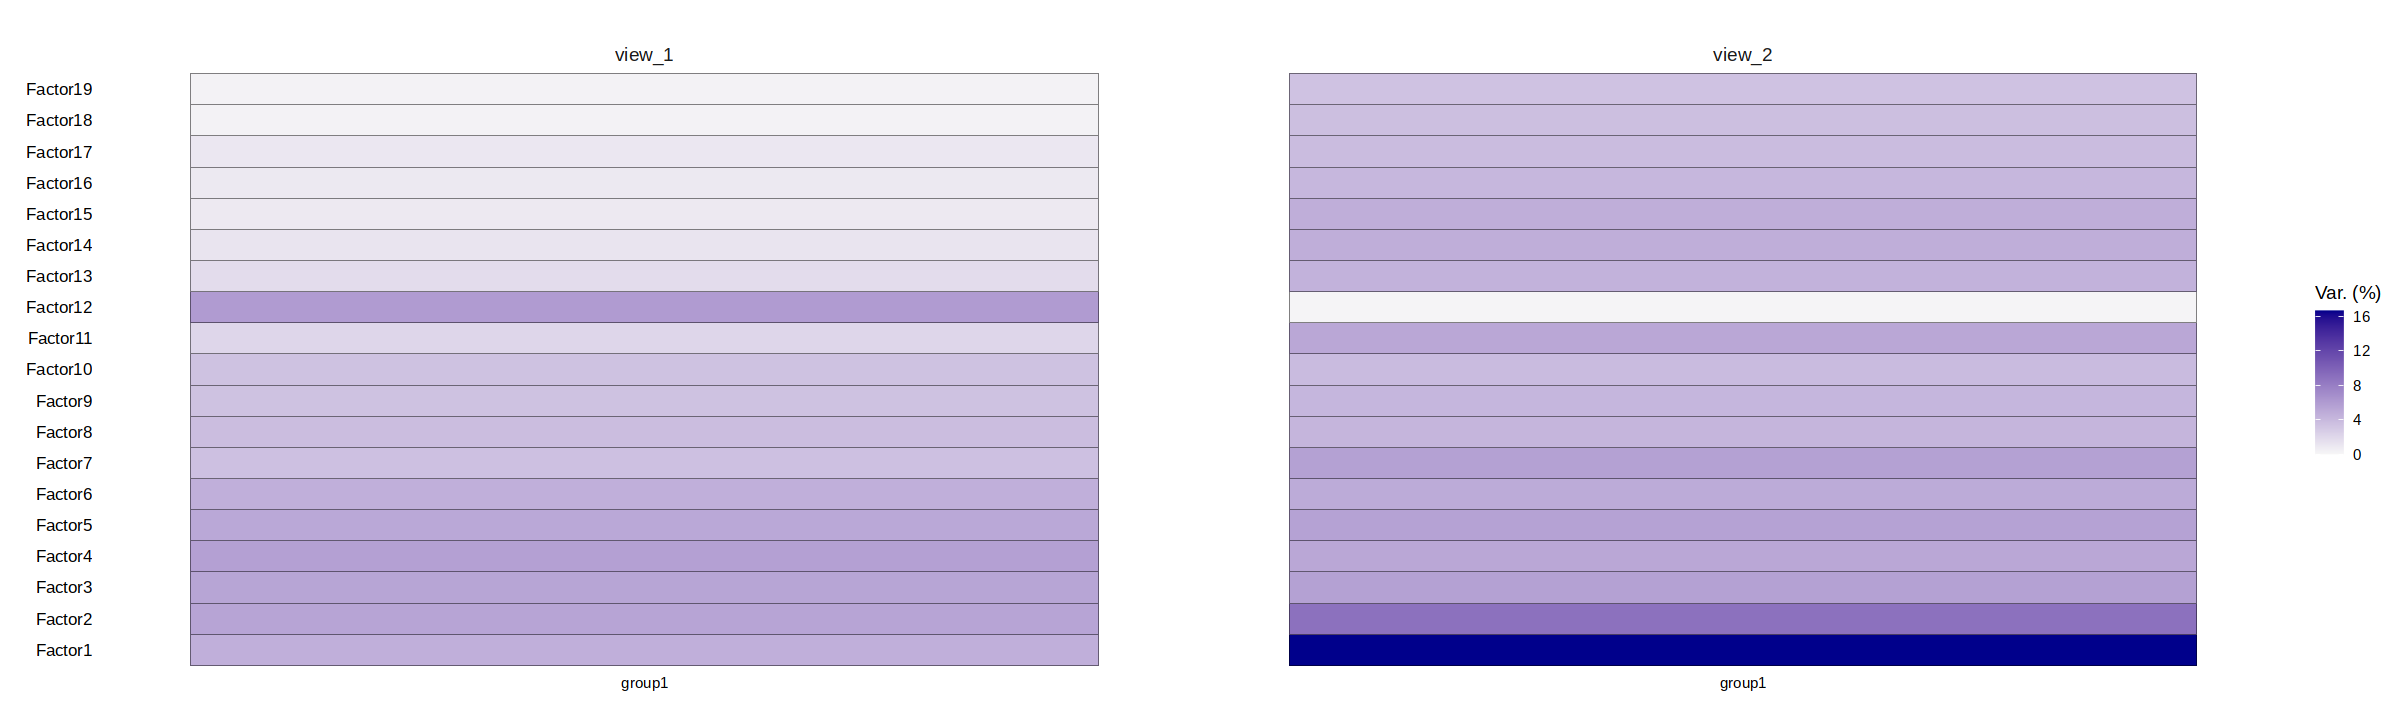

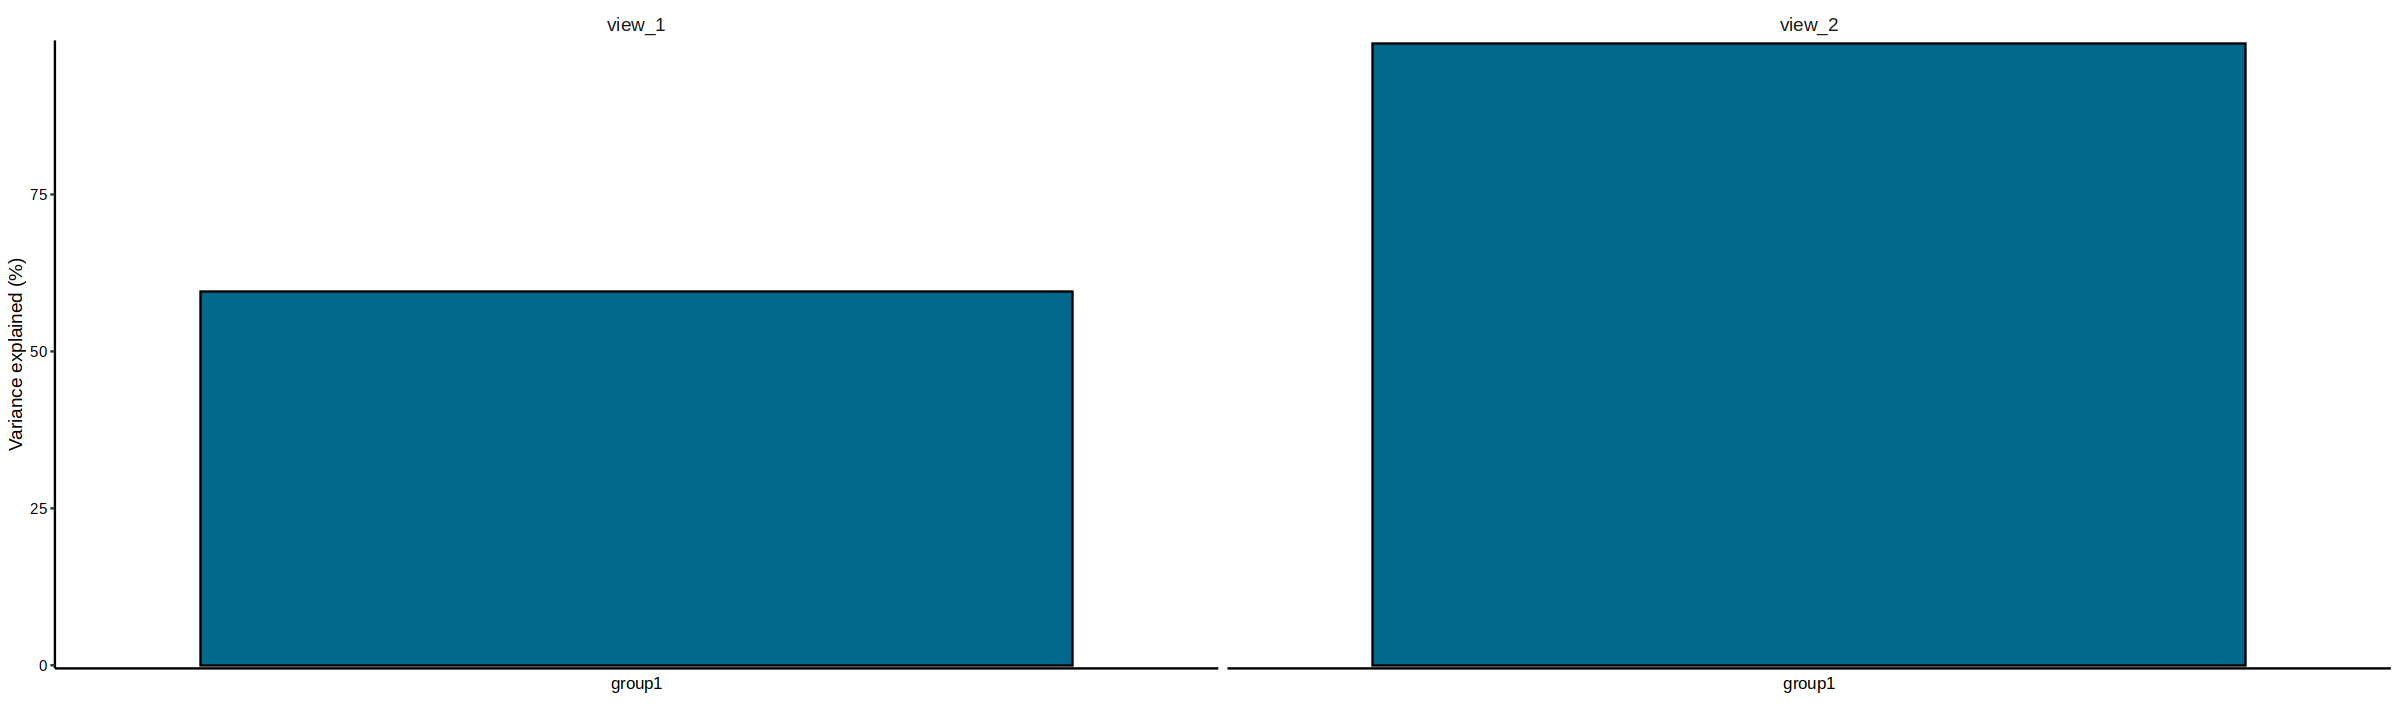

In [94]:
plot_variance_explained(MOFAobject.trained, x="group", y="factor", plot_total = T)

In [95]:
factors <- get_factors(MOFAobject.trained, factors = "all")

In [195]:
head(factors$group)

Factor1    Factor2      Factor3   
1A_Eo_DEG_G9_day3#AAACAGCCAGCAAGAT-1 -0.9493423 -0.101568811 -0.7587519
1A_Eo_DEG_G9_day3#AAACAGCCAGCACCAT-1 -1.0930037 -0.008279368 -0.6631941
1A_Eo_DEG_G9_day3#AAACATGCAAGTAAGC-1 -0.8584024 -0.111456767 -1.0401446
1A_Eo_DEG_G9_day3#AAACATGCAATATACC-1 -1.3571843  0.094370238 -0.8031028
1A_Eo_DEG_G9_day3#AAACATGCAATCCTGA-1 -1.3919386  0.288327724 -0.9594991
1A_Eo_DEG_G9_day3#AAACATGCACTTAGGC-1 -1.2654427  0.024117379 -0.9672943
                                     Factor4     Factor5    Factor6     
1A_Eo_DEG_G9_day3#AAACAGCCAGCAAGAT-1 -0.16946462 -2.2484014 -0.006249887
1A_Eo_DEG_G9_day3#AAACAGCCAGCACCAT-1 -0.21401095 -1.2967858 -0.040393185
1A_Eo_DEG_G9_day3#AAACATGCAAGTAAGC-1  0.06160452 -2.6031086 -0.131104022
1A_Eo_DEG_G9_day3#AAACATGCAATATACC-1 -0.45912793 -0.9806204 -0.061440978
1A_Eo_DEG_G9_day3#AAACATGCAATCCTGA-1 -0.37945476 -0.8975296 -0.107257709
1A_Eo_DEG_G9_day3#AAACATGCACTTAGGC-1 -0.45877907 -0.6405886 -0.273909807
                                     Factor7    Factor8     Factor9    
1A_Eo_DEG_G9_day3#AAACAGCCAGCAAGAT-1 -1.0512320 -1.11860192  1.75965691
1A_Eo_DEG_G9_day3#AAACAGCCAGCACCAT-1 -0.2486306 -0.06885262 -0.20683433
1A_Eo_DEG_G9_day3#AAACATGCAAGTAAGC-1 -1.2183871 -0.05193058  1.89684081
1A_Eo_DEG_G9_day3#AAACATGCAATATACC-1 -0.4856927  0.01550272  0.04339589
1A_Eo_DEG_G9_day3#AAACATGCAATCCTGA-1 -0.1085574 -0.25182307  0.65044576
1A_Eo_DEG_G9_day3#AAACATGCACTTAGGC-1  0.6288571 -0.25358677 -0.14125782
                                     Factor10    Factor11   Factor12   
1A_Eo_DEG_G9_day3#AAACAGCCAGCAAGAT-1  0.75156254  0.1329572 -0.29257733
1A_Eo_DEG_G9_day3#AAACAGCCAGCACCAT-1 -0.33949068  0.4877983 -0.08666006
1A_Eo_DEG_G9_day3#AAACATGCAAGTAAGC-1  0.36840186  0.2408881 -0.58308554
1A_Eo_DEG_G9_day3#AAACATGCAATATACC-1  0.43142831 -0.3850836 -1.19462514
1A_Eo_DEG_G9_day3#AAACATGCAATCCTGA-1  0.09185421 -0.7531629  1.18079531
1A_Eo_DEG_G9_day3#AAACATGCACTTAGGC-1  0.34318385 -0.2372668 -1.36580265
                                     Factor13    Factor14    Factor15  
1A_Eo_DEG_G9_day3#AAACAGCCAGCAAGAT-1  0.16198139  1.19935894  0.9609848
1A_Eo_DEG_G9_day3#AAACAGCCAGCACCAT-1 -0.67689484 -0.45537874  0.2231805
1A_Eo_DEG_G9_day3#AAACATGCAAGTAAGC-1  0.09848100  0.19402771 -0.1114902
1A_Eo_DEG_G9_day3#AAACATGCAATATACC-1 -0.03198048 -0.08910852  0.5698239
1A_Eo_DEG_G9_day3#AAACATGCAATCCTGA-1  0.45477334 -0.58295399  1.1163455
1A_Eo_DEG_G9_day3#AAACATGCACTTAGGC-1  0.13762499  0.34308547  1.8377845
                                     Factor16    Factor17   Factor18   
1A_Eo_DEG_G9_day3#AAACAGCCAGCAAGAT-1  0.22674909 -0.8812457 -0.04116518
1A_Eo_DEG_G9_day3#AAACAGCCAGCACCAT-1  0.68572277  0.4177192 -0.52033627
1A_Eo_DEG_G9_day3#AAACATGCAAGTAAGC-1 -0.33904013  0.6389883  0.34810716
1A_Eo_DEG_G9_day3#AAACATGCAATATACC-1 -0.26479185 -0.4254079  1.04884398
1A_Eo_DEG_G9_day3#AAACATGCAATCCTGA-1 -0.16956486  0.3159965  0.36230519
1A_Eo_DEG_G9_day3#AAACATGCACTTAGGC-1  0.03185394  0.2440015 -0.48712927
                                     Factor19  
1A_Eo_DEG_G9_day3#AAACAGCCAGCAAGAT-1  0.1161482
1A_Eo_DEG_G9_day3#AAACAGCCAGCACCAT-1 -1.1708112
1A_Eo_DEG_G9_day3#AAACATGCAAGTAAGC-1 -0.4164720
1A_Eo_DEG_G9_day3#AAACATGCAATATACC-1 -0.5642142
1A_Eo_DEG_G9_day3#AAACATGCAATCCTGA-1 -0.5423554
1A_Eo_DEG_G9_day3#AAACATGCACTTAGGC-1  0.2127253

In [198]:
plots = lapply(1:19, function(x){
    p = ggplot(cbind(sample_metadata, factors$group), aes_string('exp', paste0('Factor', x))) + 
            geom_violin() + 
            geom_boxplot(width=0.2, outlier.shape=NA) +
            theme_bw()
})

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation ideoms with `aes()`”


$`1`

$`2`

attr(,"class")
[1] "list"      "ggarrange"

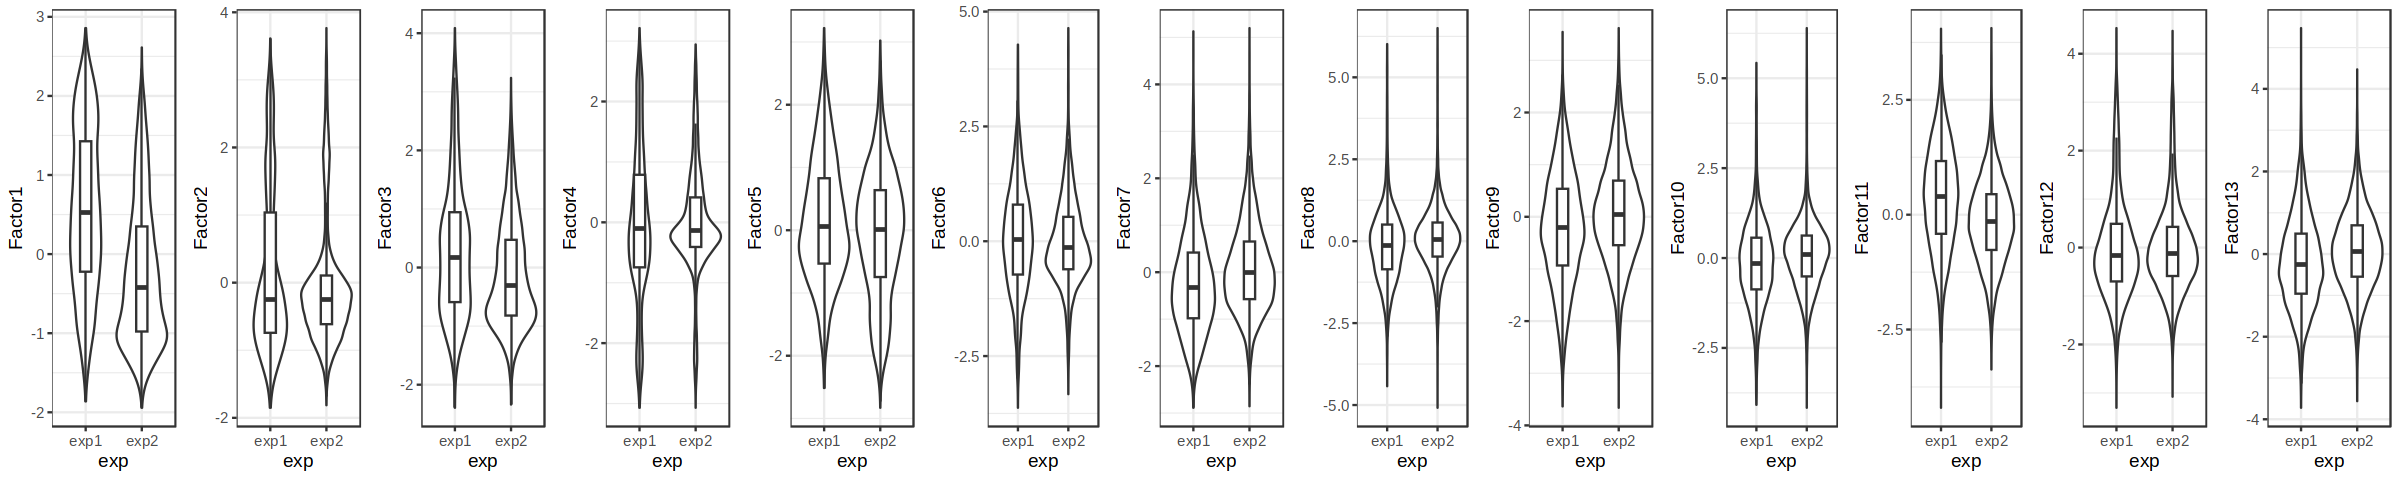

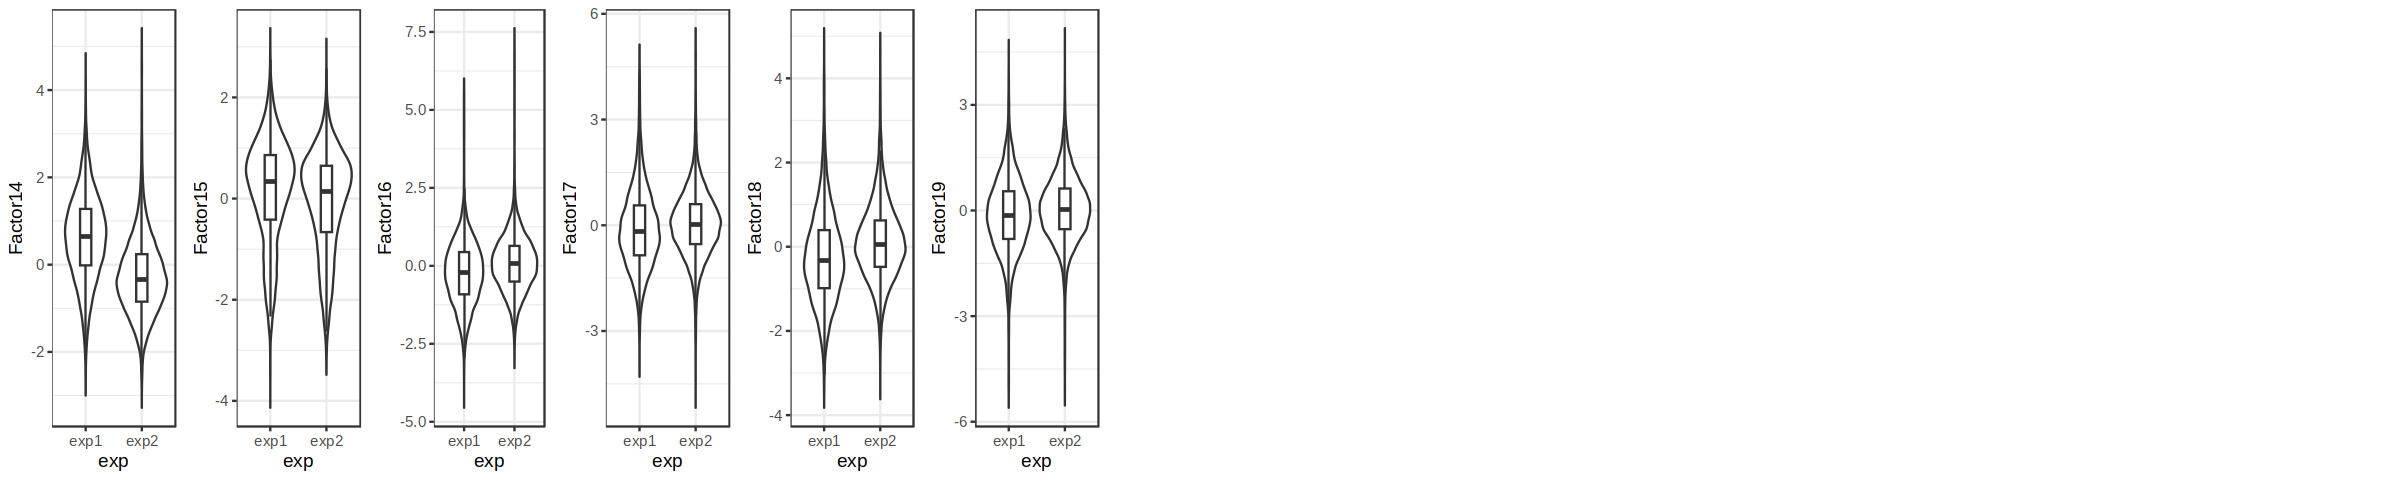

In [199]:
options(repr.plot.width=20, repr.plot.height=4)
ggarrange(plotlist=plots, ncol=13)

In [ ]:
umap = uwot::umap(factors$group1, n_neighbors = 25, min_dist = 0.15)

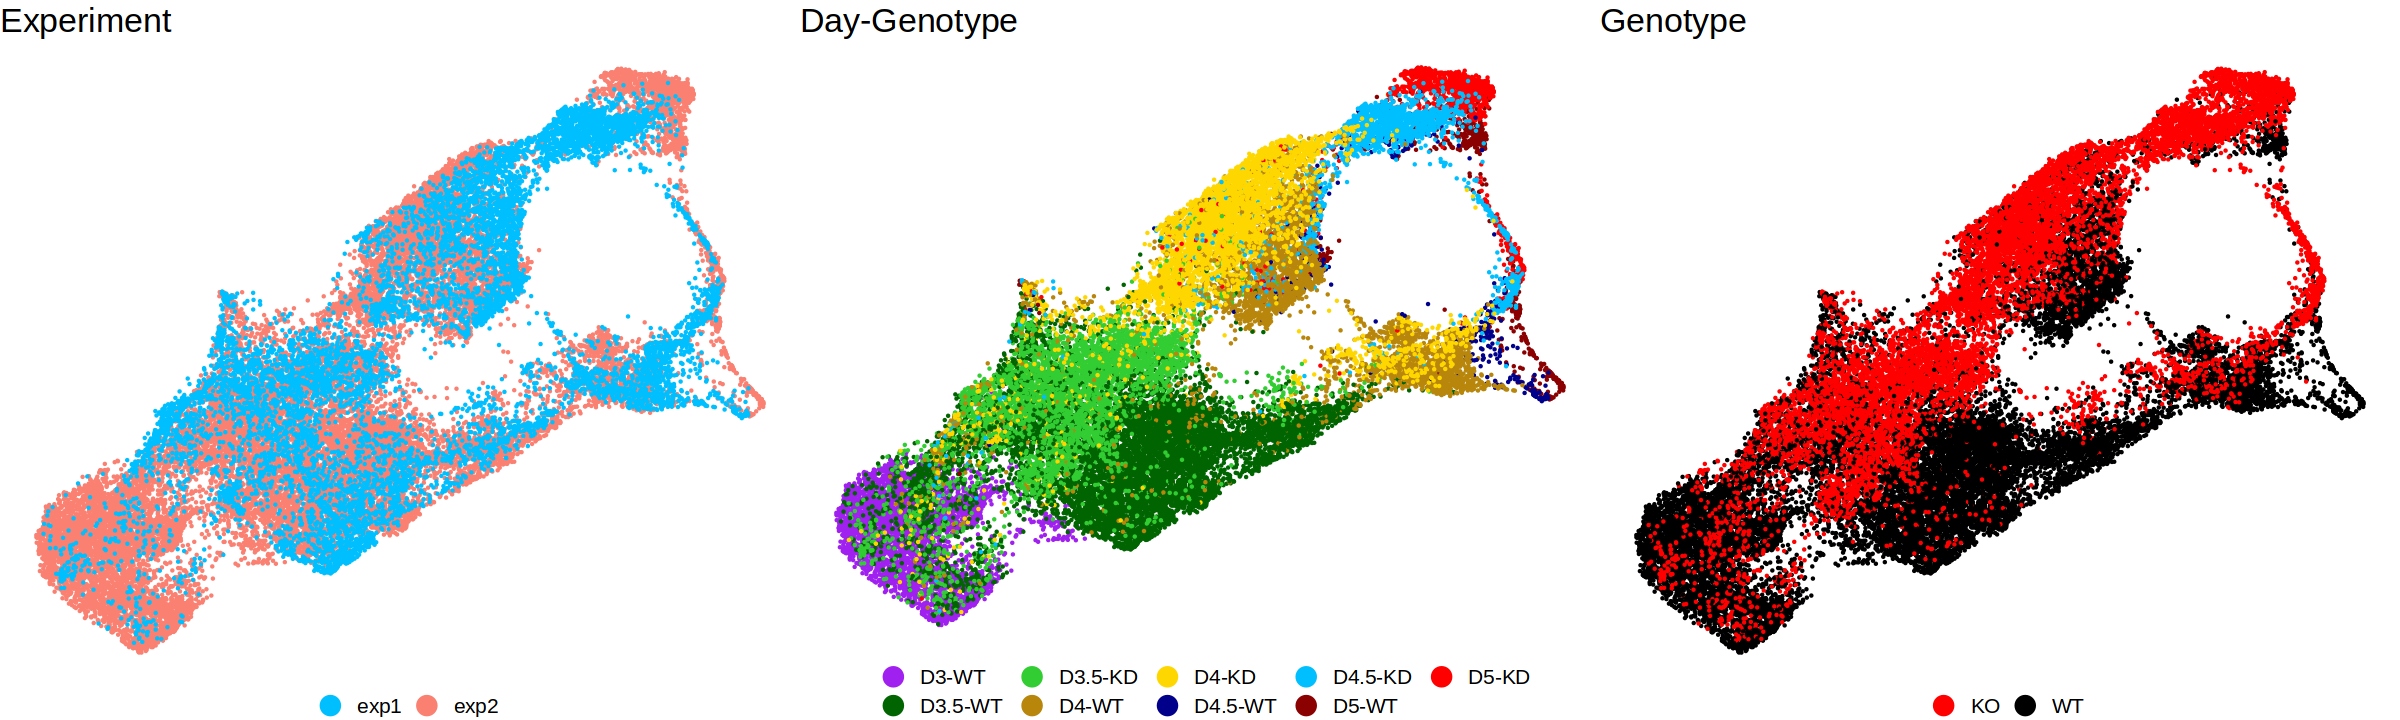

In [ ]:
umap.dt = as.data.table(umap, keep.rownames=T) %>%
    setnames(c('cell', 'UMAP1', 'UMAP2')) %>%
    .[, UMAP2:=UMAP2*-1] %>% # flip umap2 for consistency
    merge(., sample_metadata, by='cell')
plot_umap(umap.dt)

In [139]:
fwrite(as.data.table(factors$group1, keep.rownames=T) %>% setnames('rn', ' cell'), sprintf('%s/MOFA_factors.txt.gz', args$outdir))

In [140]:
fwrite(umap.dt[,c('cell', 'UMAP1', 'UMAP2')], sprintf('%s/MOFA_umap.txt.gz', args$outdir))

In [141]:
pdf(sprintf('%s/MOFA_umap.pdf', args$outdir), width=15, height=5)
    plot_umap(umap.dt)
dev.off()

png 
  2

In [240]:
umap.dt = fread(sprintf('%s/MOFA_umap.txt.gz', args$outdir))

In [241]:
plots = mclapply(1:19, function(x){
    to.plot = cbind(umap.dt, factors$group)
    p = ggplot(to.plot, aes_string('UMAP1', 'UMAP2', col = paste0('Factor', x))) + 
        geom_point(size=0.2) + 
        scale_color_gradient2(low='blue', mid='lightyellow', high='red') +
        theme_void() +
        theme(text=element_text(size=15), 
             plot.title=element_text(size=15), 
             legend.position='none')
}, mc.cores=22)

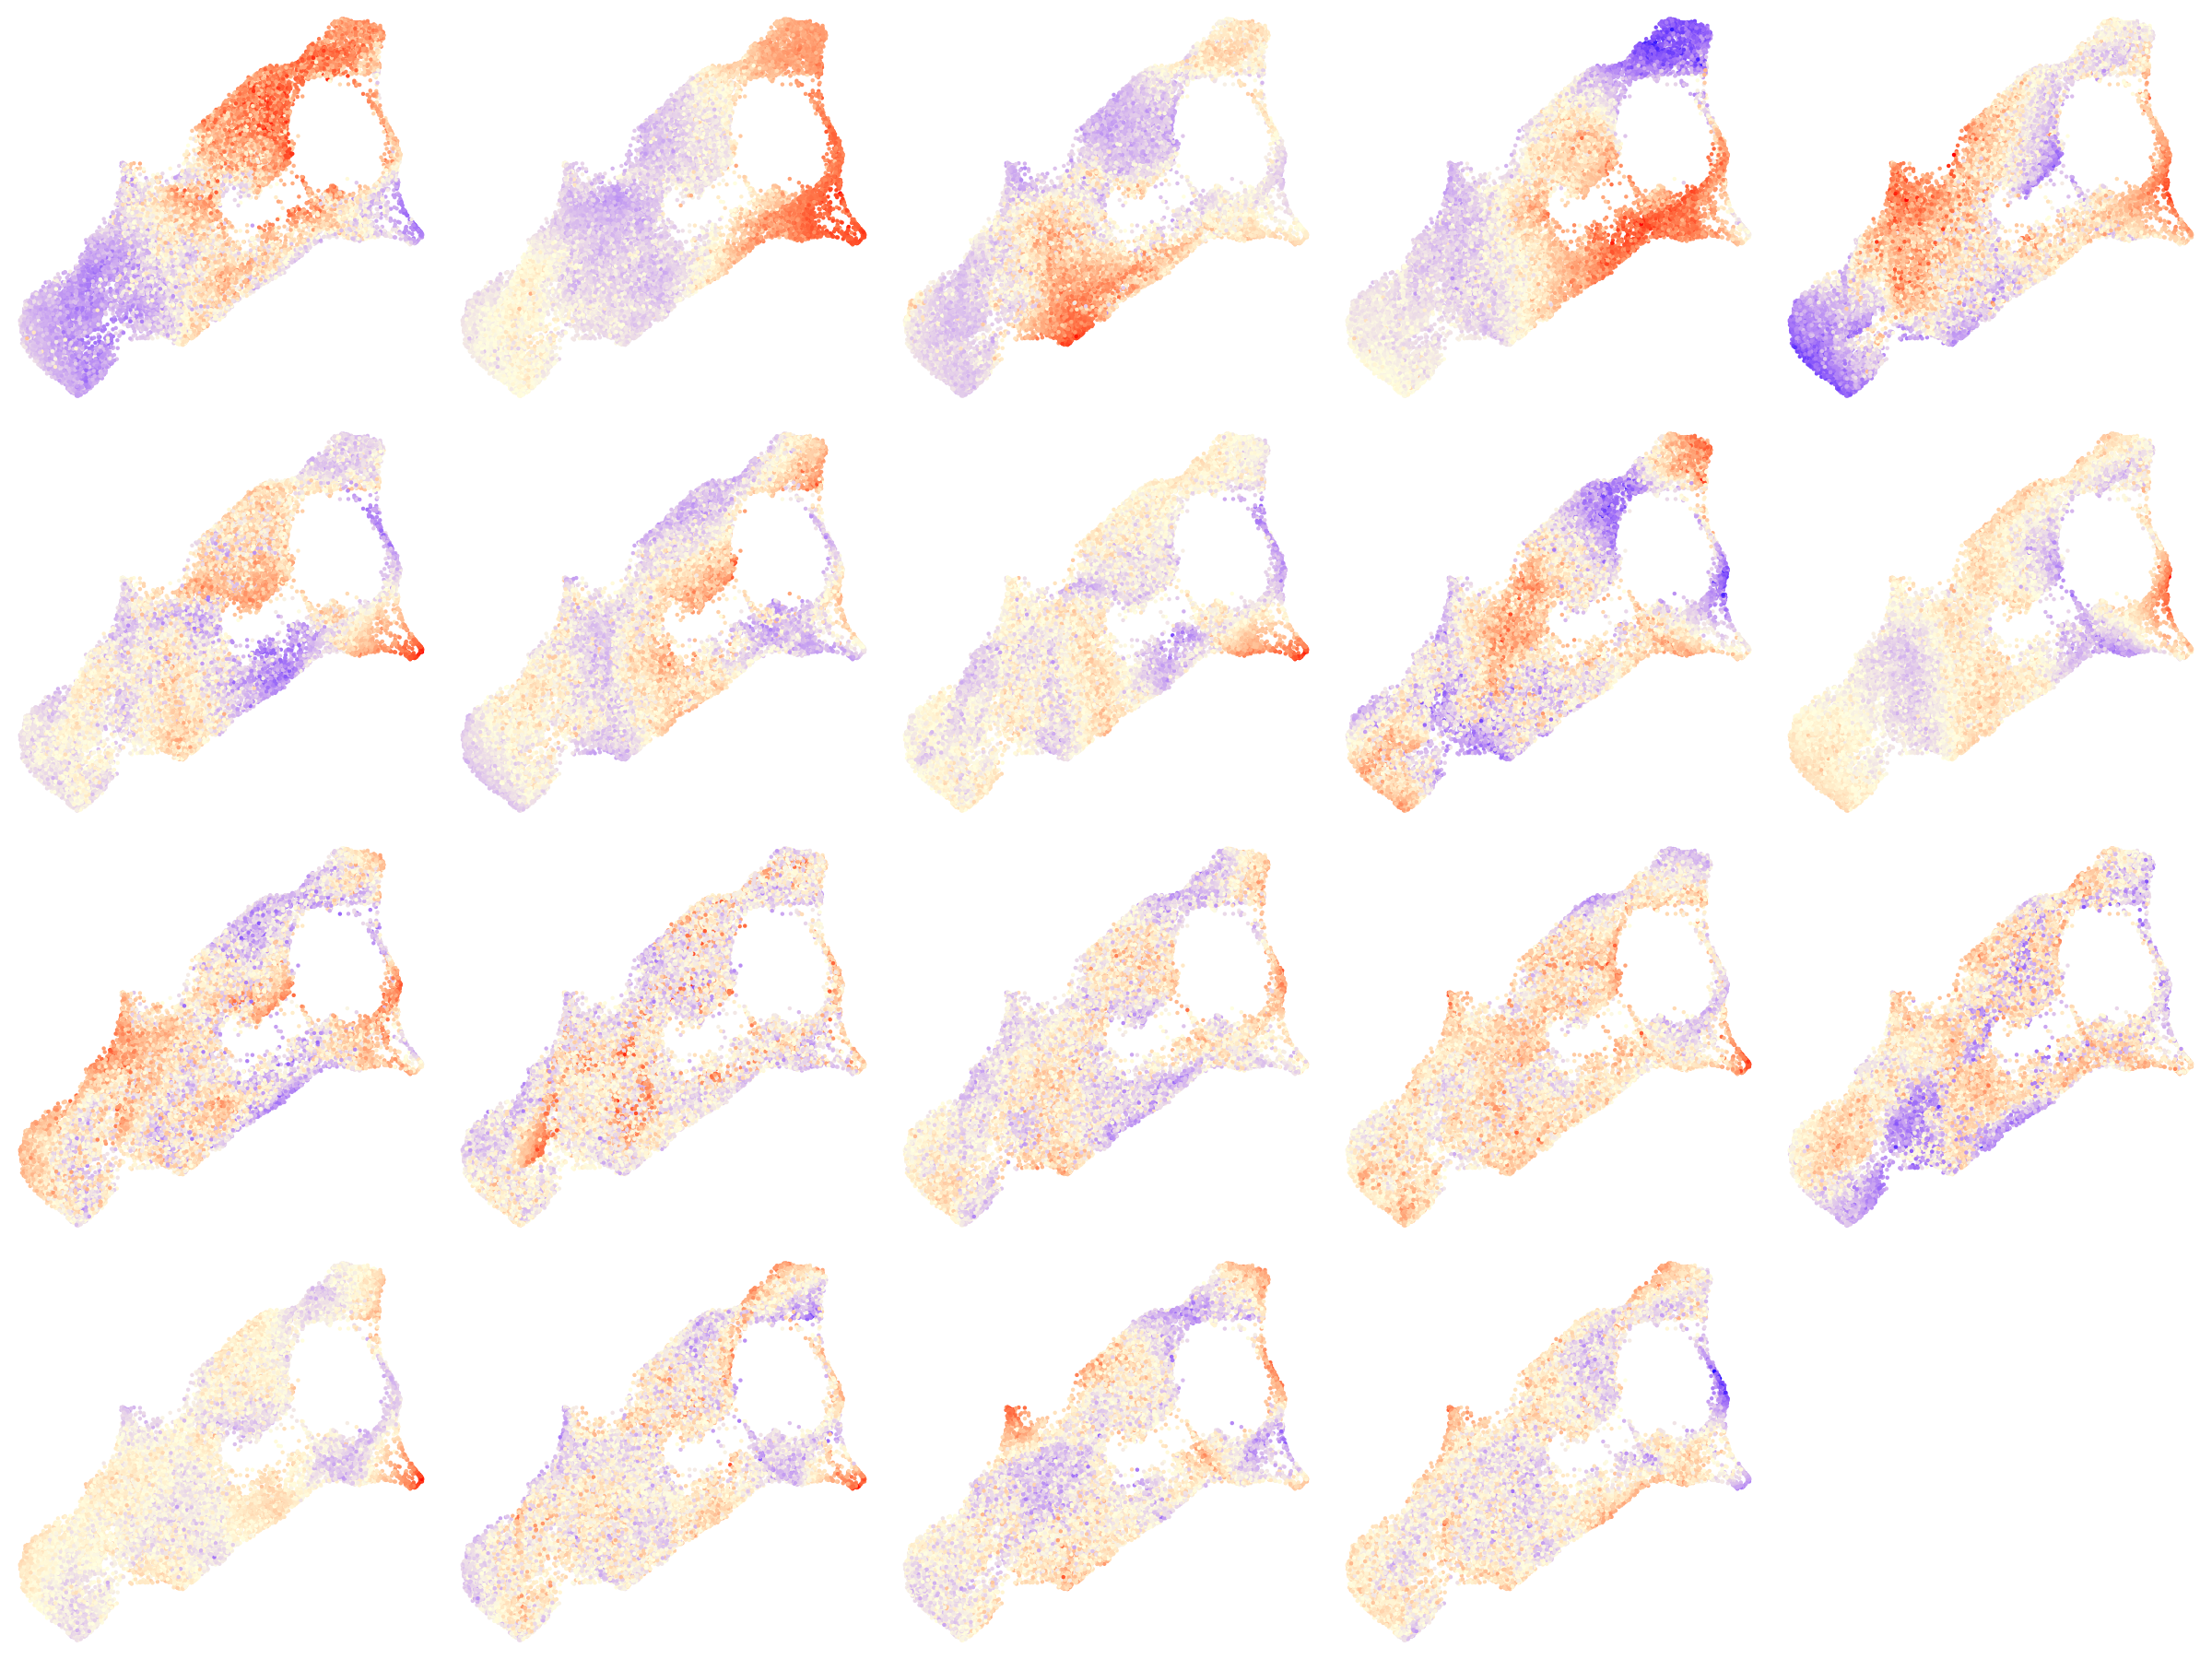

In [242]:
options(repr.plot.width=20, repr.plot.height=15)
ggarrange(plotlist=plots)